In [7]:
"""Run a zero-inflated GP on opioid data"""
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import sys
code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)
from math import radians, cos, sin, asin, sqrt
from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

from math import radians, cos, sin, asin, sqrt


import contextily as cx

from shapely.geometry import Point, Polygon

In [8]:

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [9]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results_20220606_update')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [10]:
svi_file = os.path.join(result_dir, 'svi_month')
svi_gdf = gpd.read_file(svi_file)
# Call it "grid_squar" because geopandas only supports len 10 columns
svi_gdf = svi_gdf.rename(columns={'INTPTLAT': 'lat', 'INTPTLON': 'lon', 'GEOID': 'geoid'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf


/tmp/ipykernel_288699/3528418564.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  just_tracts['points'] = just_tracts.apply(lambda x: Point(np.float(x['lon']), np.float(x['lat'])), axis=1)
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [42]:
national_zcta = gpd.read_file( os.path.join(data_dir,'shapefiles','MA_2020_ZCTA'))

# Rough crop
national_zcta = national_zcta[
    (national_zcta['INTPTLAT20'].astype(float)>41) &
    (national_zcta['INTPTLAT20'].astype(float)<43) &
    (national_zcta['INTPTLON20'].astype(float)<-69.5) &
    (national_zcta['INTPTLON20'].astype(float)> -74)]

zcta_lat_lon = national_zcta.to_crs({'init': 'epsg:4269'}) 

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [151]:
ma_2021 = gpd.read_file(os.path.join(data_dir,'shapefiles','MA_2021'))
ma_shape = ma_2021.geometry.unary_union

In [160]:
%%capture
mass_zcta = pd.DataFrame()
for _, row in national_zcta.iterrows():
    in_ma = ma_shape.contains(row.geometry)
    
    if in_ma:
        mass_zcta = mass_zcta.append(row)
mass_zcta = gpd.GeoDataFrame(mass_zcta)
mass_zcta.set_crs(national_zcta.crs)
assert(len(mass_zcta)==537)

<AxesSubplot: >

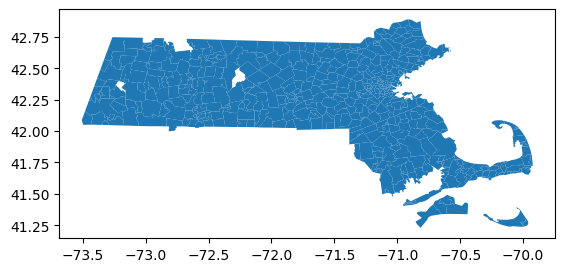

In [161]:
mass_zcta.plot()

In [44]:
matched_df = pd.read_csv(os.path.join(result_dir,'geocoded_deaths_2000_2020.csv')) 
matched_df['dod_dt'] = pd.to_datetime(matched_df['dod_dt'])
matched_df['month'] = matched_df['dod_dt'].dt.month
matched_df.loc[:,'tract'] = matched_df['tract'].astype(int)

In [45]:
matched_df['points'] = matched_df.apply(lambda x: Point(x['lon'], x['lat']), axis=1)

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [166]:
matched_df['zcta'] = ''
for i, row in matched_df.iterrows():
    zcta_contains = mass_zcta['geometry'].contains(row['points'])
    if zcta_contains.sum()==0:
        print('missing death')
        continue
    matched_df.loc[i,'zcta'] = mass_zcta[zcta_contains]['ZCTA5CE20'].values[0]

missing death
missing death


In [167]:
deaths_per_zcta_df = matched_df.groupby(['year','month','zcta']).size().reset_index(name='deaths')

In [168]:
len(deaths_per_zcta_df.zcta.unique())

488

In [178]:
deaths_gdf = gpd.GeoDataFrame()
for year in deaths_per_zcta_df.year.unique():
    for month in deaths_per_zcta_df.month.unique():
        these_deaths = deaths_per_zcta_df[(deaths_per_zcta_df['year']==year) & (deaths_per_zcta_df['month']==month)]
        years_merged_deaths = mass_zcta.merge(these_deaths,
                                              left_on='ZCTA5CE20',
                                              right_on='zcta',
                                              how='left')
        # fill NAs
        years_merged_deaths.loc[:,'year']=year
        years_merged_deaths.loc[:,'month']=month
        years_merged_deaths.loc[:,'deaths'] = years_merged_deaths.loc[:,'deaths'].fillna(0)
        deaths_gdf = deaths_gdf.append(years_merged_deaths)

deaths_gdf= deaths_gdf.reset_index(drop=True)
deaths_gdf['zcta'] = deaths_gdf['ZCTA5CE20']

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deaths_gdf = deaths_gdf.append(years_merged_deaths)
/tmp/ipykernel_288699/1523809109.py:13: FutureWarning: The frame.append method is deprecated

In [179]:
len(deaths_gdf.zcta.unique())

537

In [180]:
just_tracts = svi_gdf.loc[(svi_gdf['year']==2000)&(svi_gdf['month']==1),['geoid','geometry', 'lat', 'lon']]
just_tracts['points'] = just_tracts.apply(lambda x: Point(np.float(x['lon']), np.float(x['lat'])), axis=1)
just_zctas = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['month']==1)]

/tmp/ipykernel_288699/1944870699.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  just_tracts['points'] = just_tracts.apply(lambda x: Point(np.float(x['lon']), np.float(x['lat'])), axis=1)
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [181]:
len(just_zctas)

537

In [203]:
%%capture
svi_cols = ['theme_1_pc','theme_2_pc','theme_3_pc','theme_4_pc','svi_pctile']

zcta_svi_gdf = gpd.GeoDataFrame()
tracts_used = set()
zctas = just_zctas.ZCTA5CE20.unique()

assert(len(zctas) == len(mass_zcta) )
skipped_count=0
skipped_zctas =[]
for zcta in zctas:
    
    this_zcta = just_zctas[just_zctas.GEOID20==zcta]
    zcta_geo = this_zcta.geometry
    
    tracts_containing_zcta = just_tracts[just_tracts.geometry.intersects(zcta_geo.centroid.values[0])]
    tracts_in_zcta = just_tracts[just_tracts.geometry.centroid.intersects(zcta_geo.values[0])]
    
    if not (len(tracts_containing_zcta) or len(tracts_in_zcta)):
        skipped_count+=1
        skipped_zctas.append(zcta)
        continue
    child_tracts = set(np.append(tracts_containing_zcta.geoid.values,
                                 tracts_in_zcta.geoid.values))
    tracts_used.update(child_tracts)
    
    avg_svi = svi_gdf[svi_gdf.geoid.isin(child_tracts)].groupby(['year','month']).mean()[svi_cols].reset_index()

    this_zcta_svi = deaths_gdf.loc[deaths_gdf['ZCTA5CE20']==zcta].merge(avg_svi, on=['year','month',])
    
    zcta_svi_gdf = zcta_svi_gdf.append(this_zcta_svi)


In [207]:
svi_file = os.path.join(result_dir,'svi_month_zcta')
gpd.GeoDataFrame(zcta_svi_gdf).to_file(svi_file)

In [201]:
(1 and 0)

0

In [29]:
zcta_lat_lon.columns

Index(['ZCTA5CE20', 'GEOID20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'geometry'],
      dtype='object')

In [31]:
i

9477

In [32]:
len(matched_df)

22125

In [41]:
zcta-g

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
695,05361,05361,B5,G6350,S,73103300,5674981,+42.7872511,-072.8778300,"POLYGON ((-72.93016 42.74466, -72.93015 42.744..."
713,05257,05257,B5,G6350,S,45520961,286145,+42.9695416,-073.2627302,"POLYGON ((-73.27581 42.89711, -73.27580 42.897..."
1341,02815,02815,B5,G6350,S,7034679,182363,+41.7785905,-071.6623895,"POLYGON ((-71.67975 41.79260, -71.67750 41.792..."
1342,02838,02838,B5,G6350,S,3617800,213116,+41.9654125,-071.4793590,"POLYGON ((-71.48906 41.97548, -71.48897 41.975..."
1343,02881,02881,B5,G6350,S,8724042,20941,+41.4824293,-071.5265101,"POLYGON ((-71.54886 41.46705, -71.54883 41.467..."
...,...,...,...,...,...,...,...,...,...,...
33643,12082,12082,B5,G6350,S,49061,0,+42.7699672,-073.4466821,"POLYGON ((-73.45098 42.76935, -73.45084 42.769..."
33766,12226,12226,B5,G6350,S,951635,0,+42.6792959,-073.8098700,"POLYGON ((-73.81771 42.68065, -73.81767 42.680..."
33767,10542,10542,B5,G6350,S,76374,0,+41.3711472,-073.7643669,"POLYGON ((-73.76628 41.36977, -73.76627 41.369..."
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.73580 41.33577, -73.73501 41.335..."


In [123]:
national_zcta

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
695,05361,05361,B5,G6350,S,73103300,5674981,+42.7872511,-072.8778300,"POLYGON ((-72.93016 42.74466, -72.93015 42.744..."
713,05257,05257,B5,G6350,S,45520961,286145,+42.9695416,-073.2627302,"POLYGON ((-73.27581 42.89711, -73.27580 42.897..."
1341,02815,02815,B5,G6350,S,7034679,182363,+41.7785905,-071.6623895,"POLYGON ((-71.67975 41.79260, -71.67750 41.792..."
1342,02838,02838,B5,G6350,S,3617800,213116,+41.9654125,-071.4793590,"POLYGON ((-71.48906 41.97548, -71.48897 41.975..."
1343,02881,02881,B5,G6350,S,8724042,20941,+41.4824293,-071.5265101,"POLYGON ((-71.54886 41.46705, -71.54883 41.467..."
...,...,...,...,...,...,...,...,...,...,...
33643,12082,12082,B5,G6350,S,49061,0,+42.7699672,-073.4466821,"POLYGON ((-73.45098 42.76935, -73.45084 42.769..."
33766,12226,12226,B5,G6350,S,951635,0,+42.6792959,-073.8098700,"POLYGON ((-73.81771 42.68065, -73.81767 42.680..."
33767,10542,10542,B5,G6350,S,76374,0,+41.3711472,-073.7643669,"POLYGON ((-73.76628 41.36977, -73.76627 41.369..."
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.73580 41.33577, -73.73501 41.335..."
